<div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:0px 25px"></div>

# Classify Customer Class Categories


________________________________

**Table of contents**
    
* [Problem Statement](#problemStatement)
    
* [Exploratory Data Analysis](#eda)

* [Modeling](#ml)
    
* [Data and Model Export](#export)

* [Conclusion](#conclusion)

______________________

<a id='problemStatement'></a>

### Problem Statement

The bank wants to classify each individual customer into Class categories based on historical customer data. In this example, there are three categories: Platinum, Gold and Silver.

________
<a id='eda'></a>

### Exploratory Data Analysis

In [4]:


cust <- read.csv(paste(Sys.getenv("DSX_PROJECT_DIR"),'/datasets/class.csv',sep=""))
head(cust)



field1,CustomerID,Class,LengthOfTime,CurrentBalance,Location,Income,LineOfCredit,HomeLoan,Superanuation,EducationSaver,Investment,WorkingFulltime,AvgTrans
368,29,Platinum,7.87,3331.48,Suburban,177000,1,1,1,0,0,1,60
377,30,Platinum,5.14,2196.69,Rural,141000,0,0,0,0,0,1,46
406,31,Platinum,4.45,1002.33,Urban,196000,1,1,1,0,0,1,29
1326,47,Gold,3.20,2021.68,Rural,149000,1,1,0,0,0,0,42
2876,34,Silver,5.03,2333.22,Suburban,114000,1,1,1,1,0,1,72
1367,48,Gold,3.00,1231.73,Urban,124000,0,0,0,0,0,1,21


 #### Summary Statistics

Let's begin exploring the data by looking at some summary statistics of these events by both Class type and location.

In [5]:
#install.packages("magrittr")
library(magrittr)

In [6]:
#install.packages("dplyr")
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:SparkR’:

    arrange, between, collect, contains, count, cume_dist, dense_rank,
    desc, distinct, explain, filter, first, group_by, intersect, lag,
    last, lead, mutate, n, n_distinct, ntile, percent_rank, rename,
    row_number, sample_frac, select, sql, summarize, union

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [8]:
print("Summary Statistics by Class")
group_by(cust, Class) %>% summarise(avg_lengthOfTime = mean(LengthOfTime), avg_currentBalance = mean(CurrentBalance), avg_income = mean(Income), workingFulltime = sum(WorkingFulltime))

print("Summary Statistics by Class and Location")
aggDF <- group_by(cust, Class, Location) %>% summarise(avg_lengthOfTime = mean(LengthOfTime), avg_currentBalance = mean(CurrentBalance), avg_income = mean(Income), workingFulltime = sum(WorkingFulltime))

aggDF

[1] "Summary Statistics by Class"


Class,avg_lengthOfTime,avg_currentBalance,avg_income,workingFulltime
Gold,4.237135,2013.757,132944.44,348
Platinum,5.844743,2224.435,175716.27,714
Silver,3.160258,1560.060,99340.03,619


[1] "Summary Statistics by Class and Location"


Class,Location,avg_lengthOfTime,avg_currentBalance,avg_income,workingFulltime
Gold,Rural,3.995771,2032.7311,134568.28,124
Gold,Suburban,5.462018,2902.5218,130473.68,75
Gold,Urban,3.256856,1110.0646,133794.76,149
Platinum,Rural,5.771799,2219.2631,176029.29,239
Platinum,Suburban,7.747718,3328.1515,175879.67,236
Platinum,Urban,3.998787,1116.6554,175238.49,239
Silver,Rural,2.491429,1663.4037,98963.27,236
Silver,Suburban,4.938707,2227.8593,98844.83,166
Silver,Urban,2.029636,740.7484,100281.82,217


#### Visualization

In [9]:
#install.packages("ggplot2")
library(ggplot2)

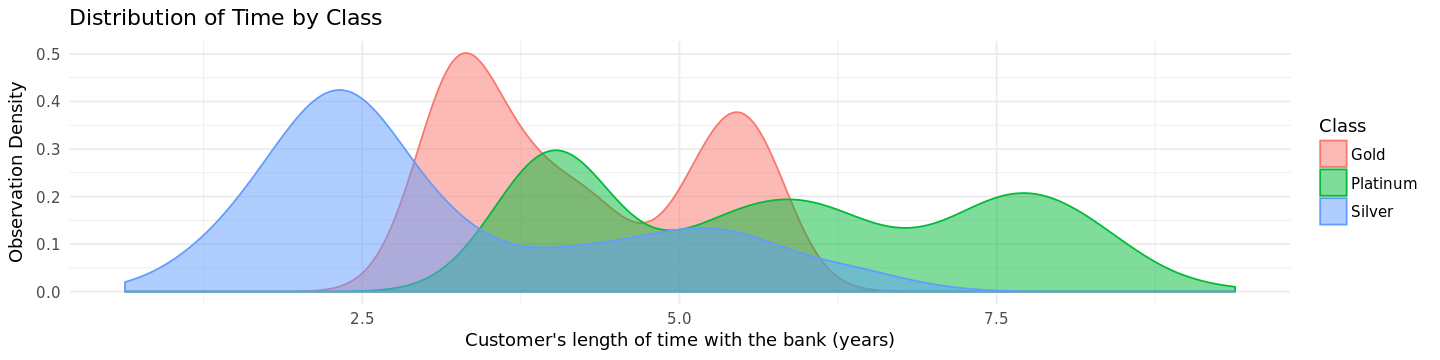

In [10]:
options(repr.plot.width = 12, repr.plot.height = 3)

ggplot(cust, aes(x = LengthOfTime, color = Class, fill = Class)) + 
    geom_density(alpha = 0.5) +
    labs(x = "Customer's length of time with the bank (years)", y = "Observation Density", title = "Distribution of Time by Class") +
    theme_minimal()

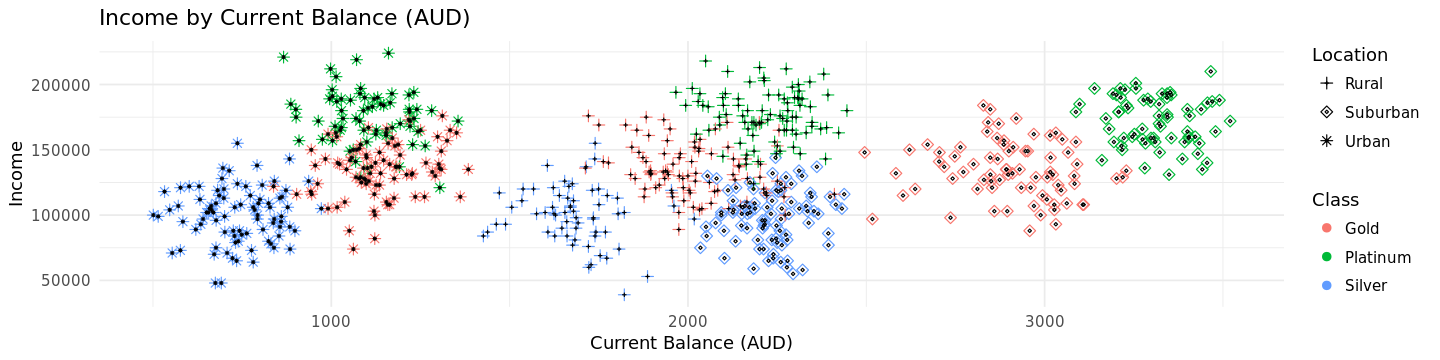

In [11]:
ggplot(sample_frac(cust, .33), aes(x = CurrentBalance, y = Income)) + 
    geom_point(aes(shape = Location, color = Class), size = 2) +
    scale_shape_manual(values=c(3, 5, 8)) +
    geom_point(color = 'black', size = 0.35, aes(shape = Location)) +
    labs(x = "Current Balance (AUD)", y = "Income", title = "Income by Current Balance (AUD)") +
    theme_minimal()

<a id='ml'></a>


### Modeling

We can train a decision tree model on the historical Class data.  It will learn the relationship between the various quantitative variables and the type of Class, allowing us to identify new customer as they come in.  In this case, we will be checking the customer affinity to a particular Class type.

In [12]:
#install.packages("caTools")
library(caTools)
#install.packages("randomForest")
library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine



#### Split data into train and test sets

In [13]:
## set the seed to make your partition reproductible
set.seed(22)

## Get row names for random sample of 70% of data
trainingRows <- row.names(cust) %in% row.names(sample_frac(cust, 0.7)) 

## Convert character columns to factor
cust$Class <- as.factor(cust$Class)
cust$Location <- as.factor(cust$Location)

## Split into train/test dataframes
trainingDF <- cust[trainingRows, ]
testingDF <- cust[!trainingRows, ]

## Check dimensions, should add up to 2100
paste("Rows in training set: ", dim(trainingDF)[1])
paste("Rows in test set: ", dim(testingDF)[1])

[1] "Rows in training set:  1470"

[1] "Rows in test set:  630"

#### Select features, train model, evaluate accuracy

In [14]:
## Preserve VINs to add on after modeling
custids <- trainingDF$CustomerID

## Select columns for modeling
trainingDF <- select(trainingDF, Class, LengthOfTime, CurrentBalance, Location, Income, 
                 LineOfCredit, HomeLoan, Superanuation,
                 EducationSaver, Investment, WorkingFulltime, AvgTrans)

ClassModel <- randomForest(Class ~ ., 
                                data = trainingDF,
                                ntree = 500,
                                proximity = TRUE)

print("Confusion Matrix for Testing Data:")
table(predict(ClassModel, select(testingDF, -CustomerID, -Class)), testingDF$Class)

[1] "Confusion Matrix for Testing Data:"


          
           Gold Platinum Silver
  Gold      211        1      1
  Platinum    1      194      0
  Silver      0        0    222

The accuracy on this model is strong enough to give us some confidence in using it on new data.  

_________

<a id='export'></a>

### Model Export

We can export the decision tree model to Object Storage for use in our Shiny app.

In [15]:
saveRDS(object = ClassModel, file = "../rstudio/Class/ClassModel.rds")

The model has successfully been written to Object Storage.  

________

### Conclusion

In this notebook we have quickly explored and visualized brake event data using R.  We've also built, tested, and exported a decision tree model that can be embedded in applications or used to create reports.  To see the Shiny app where this model is used on customers coming into the service bay, click on 'Tools --> RStudio' in the menu bar above.

_______


<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>